<a target="_blank" href="https://colab.research.google.com/github/cyneuro/CI-BioEng-Class/blob/main/cs4001_allen.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Downloading and building cells from AllenDB

Useful links:
1. [Database](http://celltypes.brain-map.org/data)
2. [Downloading biophysical models](https://allensdk.readthedocs.io/en/latest/biophysical_models.html)
3. [Example on building cells](https://alleninstitute.github.io/AllenSDK/_static/examples/nb/pulse_stimulus.html)

In [137]:
!pip install --upgrade pip
!pip install --quiet allensdk neuron

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [138]:
from allensdk.api.queries.biophysical_api import BiophysicalApi
from allensdk.model.biophys_sim.config import Config
from allensdk.model.biophysical.utils import Utils

import matplotlib.pyplot as plt

## Download the cell

In [139]:
bp = BiophysicalApi()

# Mouse Layer 5 Primary visual area neuron
# http://celltypes.brain-map.org/experiment/electrophysiology/488683425
bp.get_neuronal_models(488683425)

[{'id': 491766131,
  'name': 'Biophysical - all active_Rbp4-Cre_KL100;Ai14-203503.04.01.01',
  'neuron_reconstruction_id': 527109145,
  'neuronal_model_template_id': 491455321,
  'specimen_id': 488683425}]

In [140]:
# Download the cell with passive dendrites
bp.cache_stimulus = False # Change to False to not download the large stimulus NWB file
bp.cache_data(491766131) # 'id'

2025-02-03 03:55:01,550 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/527109147
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/527109147
2025-02-03 03:55:01,762 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/527109161
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/527109161
2025-02-03 03:55:01,883 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/395337019
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/395337019
2025-02-03 03:55:01,989 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_fi

## Build the cell

In [ ]:
# Compile the modfiles
!nrnivmodl modfiles

# Create the h object
description = Config().load('manifest.json')
utils = Utils(description)
h = utils.h

# Convert all "value" attributes to floats
for dict in utils.description.data['genome']:
    for key, value in dict.items():
        if key == 'value': dict[key] = float(value)

/usr/local/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/content
Mod files: "modfiles/modfiles/CaDynamics.mod" "modfiles/modfiles/Ca_HVA.mod" "modfiles/modfiles/Ca_LVA.mod" "modfiles/modfiles/Ih.mod" "modfiles/modfiles/Im.mod" "modfiles/modfiles/Im_v2.mod" "modfiles/modfiles/Kd.mod" "modfiles/modfiles/K_P.mod" "modfiles/modfiles/K_T.mod" "modfiles/modfiles/Kv2like.mod" "modfiles/modfiles/Kv3_1.mod" "modfiles/modfiles/Nap.mod" "modfiles/modfiles/NaTa.mod" "modfiles/modfiles/NaTs.mod" "modfiles/modfiles/NaV.mod" "modfiles/modfiles/SK.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


In [145]:
# Configure morphology
manifest = description.manifest
morphology_path = description.manifest.get_path('MORPHOLOGY')
utils.generate_morphology(morphology_path.encode('ascii', 'ignore'))

# Specify passive properties
passive = {
      "ra": 100,
      "cm": [
        {
          "section": "soma",
          "cm": 1
        },
        {
          "section": "axon",
          "cm": 1
        },
        {
          "section": "dend",
          "cm": 1
        },
        {
          "section": "apic",
          "cm": 1
        }
      ],
      "e_pas": -65.75
}
utils.description.data["passive"][0] = passive
utils.load_cell_parameters()

In [155]:
# Set current injection
stim = h.IClamp(h.soma[0](0.5))
stim.amp = 1.0
stim.delay = 100.0
stim.dur = 800.0
h.tstop = 1000.0

In [156]:
vec = utils.record_values()

In [157]:
h.finitialize()
h.run()

0.0

Text(0, 0.5, 'Voltage (mV)')

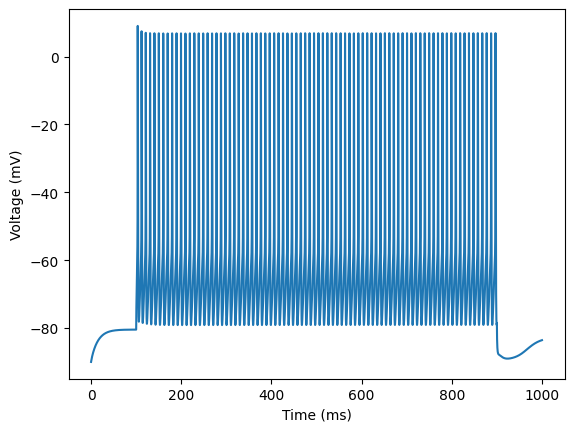

In [159]:
plt.plot(vec['t'].as_numpy(), vec['v'].as_numpy())
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")

## Homework

1. Choose any active mouse cell model from the [database](http://celltypes.brain-map.org/data). When searching, put "Has All-active Biophysical model" on.
2. Simulate the cell for different values of current injection (CI). Plot voltage responses (t vs V) for each CI. Then plot the FI curve.